In [33]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

In [34]:
import os 
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
import numpy as np 
import pickle

%matplotlib inline

In [35]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [36]:
detector = MTCNN()  # creates detector  

def extract_face(img, target_size=(224,224)):
    '''this functions extract the face from different images by 
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''
           
    # 1. detect faces in an image
      
    results = detector.detect_faces(img)
    if results == []:    # if face is not detected, call function to crop & resize by keeping aspect ratio
        new_face = crop_and_resize(img, target_w=224, target_h=224)    
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2    
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)    

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)   
    return sqr_img


In [37]:
y_label_dict = {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

def predict_face_shape(img_array):
    '''
    this function reads a single image in the form of an array, 
    and process the image then make predictions.
    '''
    try:
        # first extract the face using bounding box
        face_img = extract_face(img_array)  # call function to extract face with bounding box
        new_img = cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB) # convert to RGB -- use this for display          
        # convert the image for modelling
        test_img = np.array(new_img, dtype=float)
        test_img = test_img/255
        test_img = np.array(test_img).reshape(1, 224, 224, 3)  
        # make predictions
        pred = model.predict(test_img)        
        label = np.argmax(pred,axis=1)
        shape = y_label_dict[label[0]]
        print(f'Your face shape is {shape}')
        pred = np.max(pred)
        print(f'Probability {np.around(pred*100,2)}')
        plt.imshow(new_img)
    except Exception as e:
        print(f'Oops!  Something went wrong.  Please try again.')



In [38]:
# Transfer Learning model from VGG-Face

transfer_path = 'C:/Users/whisn/FaceShape Dataset/saved_models/'
transfer_file = transfer_path + 'vgg16-face-2.keras'
model = tf.keras.models.load_model(transfer_file)

C:\Users\whisn\New folder\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [39]:
# create path to images in model_testing

test_path = 'C:/Users/whisn/FaceShape Dataset/model_testing'
test_files = os.listdir(test_path)

test_img = []

for i in test_files:
    img = os.path.join(test_path,i)
    test_img.append(img)
    


In [40]:
image_list = []
for i, file in enumerate(test_img):
  image_list.append(cv2.imread(os.path.join(test_path,file)))
len(image_list)

1

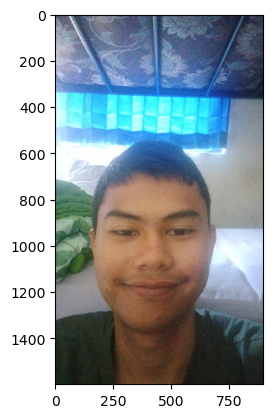

In [41]:
plt.imshow(cv2.cvtColor(image_list[0],cv2.COLOR_BGR2RGB));

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
Your face shape is Round
Probability 66.33


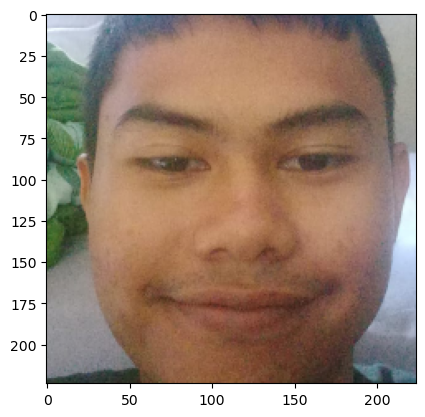

In [42]:
predict_face_shape(image_list[0])

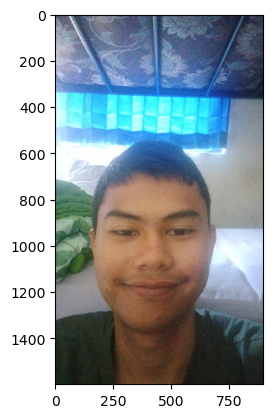

In [44]:
plt.imshow(cv2.cvtColor(image_list[0],cv2.COLOR_BGR2RGB));

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Your face shape is Round
Probability 66.33


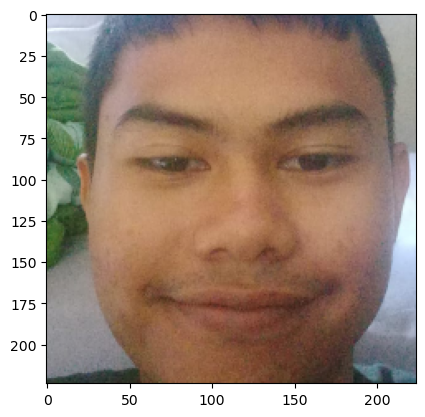

In [45]:
predict_face_shape(image_list[0])